In [38]:
# File: ResNet50_Model.ipynb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os

In [39]:
# --- 1. Parameters & Data Loading ---

print("--- Downloading and Extracting Dataset ---")

zip_path = tf.keras.utils.get_file(
    origin='https://zenodo.org/records/16749554/files/PY-CrackDB.zip?download=1',
    fname='PY-CrackDB.zip',
    extract=True,
    archive_format='zip'
)


base_dir = os.path.dirname(zip_path)
extracted_dir_name = 'PY-CrackDB_extracted'
data_dir = os.path.join(base_dir, extracted_dir_name, 'Classification')

print(f"Data successfully downloaded and extracted.")
print(f"Using data from: {data_dir}")

--- Downloading and Extracting Dataset ---
Data successfully downloaded and extracted.
Using data from: /root/.keras/datasets/PY-CrackDB_extracted/Classification


In [40]:
# --- 1b. Set Model & Training Parameters ---

IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
NUM_CLASSES = 2
VALIDATION_SPLIT = 0.2


EPOCHS_HEAD = 5
EPOCHS_FINE_TUNE = 8
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE_TUNE = 1e-5


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

print("\nLoading Training Data:")
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

print("\nLoading Validation Data:")
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(f"\nClass indices: {train_generator.class_indices}")
class_labels = list(train_generator.class_indices.keys())



Loading Training Data:
Found 456 images belonging to 2 classes.

Loading Validation Data:
Found 113 images belonging to 2 classes.

Class indices: {'With crack': 0, 'Without crack': 1}


In [41]:
# --- 2. Model Building (Transfer Learning) ---


base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [42]:
# --- 3. Initial Training (Head Only) ---

print("\n--- Training classification head ---")
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_HEAD),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time_train_head = time.time()
history_head = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_HEAD
)
end_time_train_head = time.time()
print(f"Head training time: {end_time_train_head - start_time_train_head:.2f} seconds")



--- Training classification head ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.5341 - loss: 1.0310 - val_accuracy: 0.6667 - val_loss: 0.6054
Epoch 2/5
 1/14 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - accuracy: 0.6562 - loss: 0.6366

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6562 - loss: 0.6366 - val_accuracy: 0.6771 - val_loss: 0.6000
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.6369 - loss: 0.6613 - val_accuracy: 0.6354 - val_loss: 0.6461
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6562 - loss: 0.6593 - val_accuracy: 0.6979 - val_loss: 0.6369
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 143s 11s/step - accuracy: 0.6465 - loss: 0.6457 - val_accuracy: 0.6458 - val_loss: 0.5666
Head training time: 396.60 seconds


In [43]:
# --- 4. Fine-Tuning (Unfreeze layers) ---
print("\n--- Fine-tuning model ---")


base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block1_out':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time_fine_tune = time.time()
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    initial_epoch=history_head.epoch[-1]
)
end_time_fine_tune = time.time()
total_training_time = (end_time_train_head - start_time_train_head) + (end_time_fine_tune - start_time_fine_tune)
print(f"Fine-tuning time: {end_time_fine_tune - start_time_fine_tune:.2f} seconds")
print(f"Total training time: {total_training_time:.2f} seconds")


--- Fine-tuning model ---
Epoch 5/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.6856 - loss: 0.6091 - val_accuracy: 0.6875 - val_loss: 0.6251
Epoch 6/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7500 - loss: 0.4910 - val_accuracy: 0.6771 - val_loss: 0.6251
Epoch 7/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 139s 10s/step - accuracy: 0.8712 - loss: 0.3998 - val_accuracy: 0.3854 - val_loss: 0.7428
Epoch 8/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8125 - loss: 0.4361 - val_accuracy: 0.3646 - val_loss: 0.7564
Fine-tuning time: 348.00 seconds
Total training time: 744.60 seconds


In [ ]:
# --- 5. Evaluation ---

print("\n--- Evaluating model on validation set ---")


eval_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

evaluation_generator = eval_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

start_time_test = time.time()


Y_pred_probs = model.predict(evaluation_generator, steps=evaluation_generator.samples)
Y_pred_labels = np.argmax(Y_pred_probs, axis=1)
Y_true_labels = evaluation_generator.classes

end_time_test = time.time()
testing_time = end_time_test - start_time_test
print(f"Evaluation time (on validation set): {testing_time:.2f} seconds")


In [44]:
#  Accuracy (Overall)
overall_accuracy = accuracy_score(Y_true_labels, Y_pred_labels)
print(f"\nOverall Accuracy: {overall_accuracy * 100:.2f}%")


Overall Accuracy: 36.28%


In [ ]:
 # Confusion Matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
print("\nConfusion Matrix:")
print(cm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('ResNet50 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [45]:
# Class Accuracy (from CM)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nClass-wise Accuracy:")
for i, label in enumerate(class_labels):
    print(f"{label}: {class_accuracies[i] * 100:.2f}%")



Class-wise Accuracy:
With crack: 1.37%
Without crack: 100.00%


In [46]:
#  Precision, Recall, F1-score
print("\nClassification Report:")
print(classification_report(Y_true_labels, Y_pred_labels, target_names=class_labels))



Classification Report:
               precision    recall  f1-score   support

   With crack       1.00      0.01      0.03        73
Without crack       0.36      1.00      0.53        40

     accuracy                           0.36       113
    macro avg       0.68      0.51      0.28       113
 weighted avg       0.77      0.36      0.20       113




--- AUC & ROC Curve ---

Overall AUC Score: 1.0000


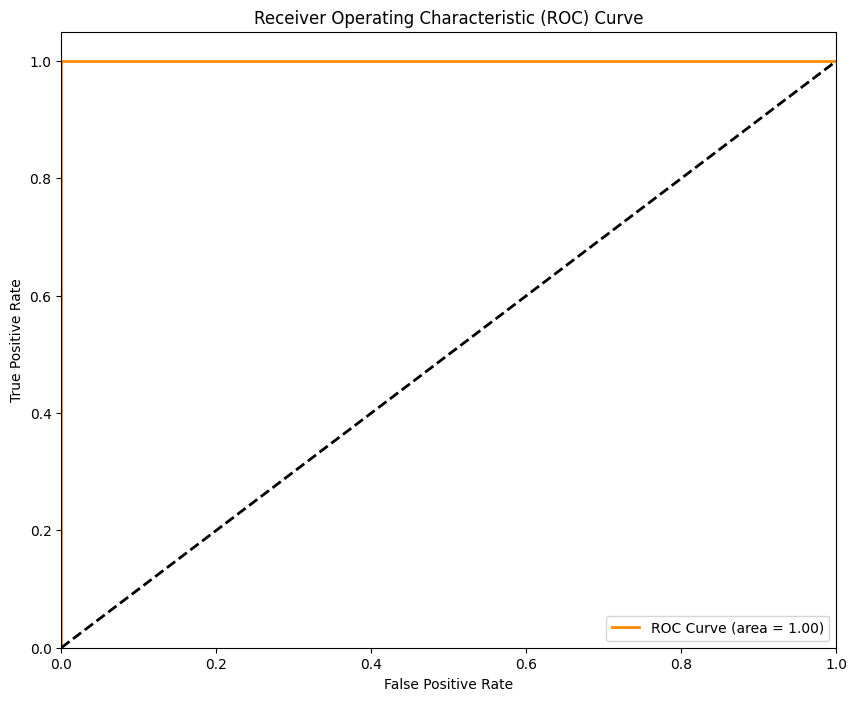

NameError: name 'roc_auc' is not defined

<Figure size 1000x800 with 0 Axes>

In [47]:
# 5. AUC & ROC Curve
#
print("\n--- AUC & ROC Curve ---")


positive_class_probs = Y_pred_probs[:, 1]


auc_score = roc_auc_score(Y_true_labels, positive_class_probs)
print(f"\nOverall AUC Score: {auc_score:.4f}")

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_true_labels, positive_class_probs)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


print(f"\nTotal Training Time: {total_training_time:.2f}s")
print(f"Evaluation Time: {testing_time:.2f}s")


model.save('resnet50_fine_tuned_model.h5')
print("\nModel saved as resnet50_fine_tuned_model.h5")